In [1]:
B, C, H, W = 1, 1, 28, 28
patch_size = 7
import torch
x = torch.randn(B, C, H, W)  # Random MNIST-like image
print(x.shape)
x = x.unfold(2, patch_size, patch_size)
print(x)
x = x.unfold(3, patch_size, patch_size)
x.shape

torch.Size([1, 1, 28, 28])
tensor([[[[[ 9.6962e-02, -7.6492e-01, -1.3925e+00, -5.5471e-01, -4.4691e-01,
            -9.7547e-01,  1.2357e+00],
           [-2.3877e-02, -4.4211e-01,  2.8608e-01, -9.5456e-01,  1.2000e+00,
            -1.3013e+00, -9.6548e-03],
           [-1.6400e-01,  2.2063e+00, -3.7777e-01, -1.3336e+00, -1.6784e-01,
             6.4098e-01, -1.1363e+00],
           [-5.7483e-01, -4.4286e-01,  1.1530e+00,  5.3064e-01, -2.4013e-01,
            -1.6424e+00, -8.3910e-01],
           [-2.4759e-01,  1.0104e+00,  2.9470e-01,  1.7030e-01, -3.1150e-01,
             1.1031e+00,  6.5606e-01],
           [-4.8599e-01, -6.0727e-01, -2.0251e-02, -7.0940e-01,  9.5781e-01,
            -1.2819e+00, -1.0873e+00],
           [ 6.5064e-01,  1.1220e+00, -8.0758e-01,  6.1394e-01,  7.1736e-01,
             1.2679e+00,  5.9945e-01],
           [-2.5126e+00, -1.0211e+00,  2.5045e+00,  1.1827e+00,  3.3354e-01,
            -3.9469e-01, -8.9460e-01],
           [ 8.5355e-01, -5.2838e-01,  7.1513

torch.Size([1, 1, 4, 4, 7, 7])

In [11]:
image = torch.tensor([
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 11, 12],
    [13, 14, 15, 16]
]).float().unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 4, 4)

image, image.shape

(tensor([[[[ 1.,  2.,  3.,  4.],
           [ 5.,  6.,  7.,  8.],
           [ 9., 10., 11., 12.],
           [13., 14., 15., 16.]]]]),
 torch.Size([1, 1, 4, 4]))

In [30]:
image[:, :, :, :].unfold(3, 2, 2)

tensor([[[[[ 1.,  2.],
           [ 3.,  4.]],

          [[ 5.,  6.],
           [ 7.,  8.]],

          [[ 9., 10.],
           [11., 12.]],

          [[13., 14.],
           [15., 16.]]]]])

In [34]:
patch_size = 2
patches = image.unfold(2, patch_size, patch_size)
print(patches)
# print(patches)
patches = patches.unfold(3, patch_size, patch_size)
print(patches)
print(patches.permute(0, 2, 3, 1, 4, 5).shape)
print(patches.permute(0, 2, 3, 1, 4, 5).contiguous())

tensor([[[[[ 1.,  5.],
           [ 2.,  6.],
           [ 3.,  7.],
           [ 4.,  8.]],

          [[ 9., 13.],
           [10., 14.],
           [11., 15.],
           [12., 16.]]]]])
tensor([[[[[[ 1.,  2.],
            [ 5.,  6.]],

           [[ 3.,  4.],
            [ 7.,  8.]]],


          [[[ 9., 10.],
            [13., 14.]],

           [[11., 12.],
            [15., 16.]]]]]])
torch.Size([1, 2, 2, 1, 2, 2])
tensor([[[[[[ 1.,  2.],
            [ 5.,  6.]]],


          [[[ 3.,  4.],
            [ 7.,  8.]]]],



         [[[[ 9., 10.],
            [13., 14.]]],


          [[[11., 12.],
            [15., 16.]]]]]])


Epoch [1/5], Loss: 0.3490
Epoch [2/5], Loss: 0.1460
Epoch [3/5], Loss: 0.1135
Epoch [4/5], Loss: 0.0964
Epoch [5/5], Loss: 0.0896
Test Accuracy: 97.62%


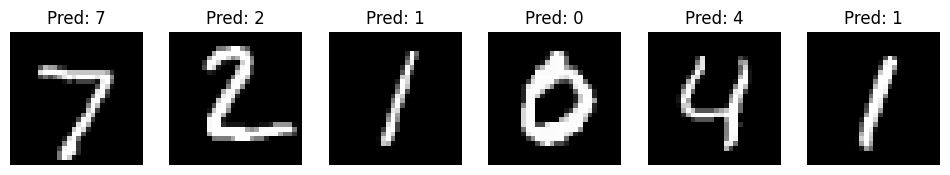

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# ----------------- Data Preparation -----------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# ----------------- Vision Transformer (ViT) -----------------
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=28, patch_size=7, in_channels=1, embed_dim=128):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Linear(patch_size * patch_size * in_channels, embed_dim)

    def forward(self, x):
        B, C, H, W = x.shape  # (B, 1, 28, 28)
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)  
        # Now shape is (B, C, num_patches_H, num_patches_W, patch_size, patch_size)

        x = x.permute(0, 2, 3, 1, 4, 5).contiguous()  
        # Shape: (B, num_patches_H, num_patches_W, C, patch_size, patch_size)

        x = x.view(B, self.num_patches, -1)  # Flatten patches: (B, 16, 49)
        x = self.proj(x)  # Linear projection: (B, 16, embed_dim)
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]  # Self-attention
        x = x + self.mlp(self.norm2(x))  # Feed-forward network
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size=28, patch_size=7, in_channels=1, embed_dim=128, depth=4, num_heads=4, num_classes=10):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, self.patch_embed.num_patches + 1, embed_dim))
        self.dropout = nn.Dropout(0.1)
        self.encoder = nn.Sequential(*[TransformerEncoder(embed_dim, num_heads) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)  # (B, num_patches, embed_dim)
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, embed_dim)
        x = torch.cat([cls_tokens, x], dim=1)  # (B, num_patches + 1, embed_dim)
        x = x + self.pos_embed  # Add positional encoding
        x = self.dropout(x)
        x = self.encoder(x)  # Transformer encoder
        x = self.norm(x[:, 0])  # Take [CLS] token output
        return self.head(x)

# ----------------- Model Training -----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionTransformer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

# ----------------- Model Testing -----------------
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# ----------------- Visualize Predictions -----------------
def visualize_predictions():
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, 6, figsize=(12, 2))
    for i in range(6):
        axes[i].imshow(images[i].cpu().squeeze(), cmap="gray")
        axes[i].set_title(f"Pred: {predicted[i].item()}")
        axes[i].axis("off")
    plt.show()

visualize_predictions()


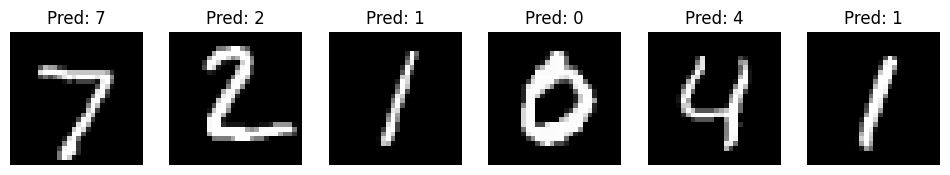

In [4]:
def visualize_predictions():
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, 6, figsize=(12, 2))
    for i in range(6):
        axes[i].imshow(images[i].cpu().squeeze(), cmap="gray")
        axes[i].set_title(f"Pred: {predicted[i].item()}")
        axes[i].axis("off")
    plt.show()

visualize_predictions()

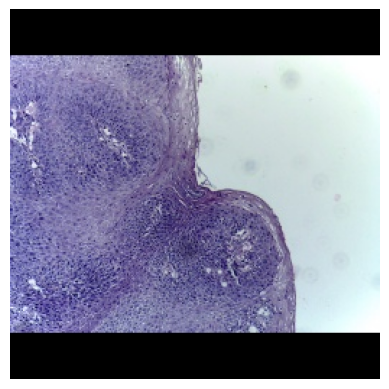

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg  # Optional, for reading images

# Load image
img = mpimg.imread(r'F:\works\A-important\A-neurals\ViT\asset\Data\test\OSCC\OSCC_100x_20.jpg')

# Display image
plt.imshow(img)
plt.axis('off')  # Optional, removes axes
plt.show()


In [6]:
img.shape

(256, 256, 3)